In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(44)

In [3]:
import json
import time
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from data.othello import Othello, OthelloBoardState
from mingpt.dataset import CharDataset
from mingpt.model import GPT, GPTConfig, GPTforProbing
from mingpt.probe_trainer import Trainer, TrainerConfig
from mingpt.probe_model import BatteryProbeClassification, BatteryProbeClassificationTwoLayer

In [4]:
# loading probes
exp = "state_tl256_b95"
probes = {}
for layer in range(1, 9):
    p = BatteryProbeClassificationTwoLayer(torch.cuda.current_device(), probe_class=3, num_task=64, mid_dim=256)
    load_res = p.load_state_dict(torch.load(f"./ckpts/bias/probes/{exp}/layer{layer}/checkpoint.ckpt"))
    p.eval()
    probes[layer] = p

In [5]:
othello = Othello(n_games=100, deduplicate=False)
train_dataset = CharDataset(othello)

mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)
model = GPTforProbing(mconf)

Mem Used: 3.408 GB:   0%|          | 0/50 [00:00<?, ?it/s]


Loaded 100000 from 1 files
Using 80 for training, 20 for validation
Dataset created has 80 sequences, 61 unique words.


In [5]:
# summarizing probe loss

root = f"ckpts/bias_finetune/probes/state_tl256_100_e10"
errs = []
for i in range(8):
    name = f"layer{i+1}/tensorboard.txt"
    with open(f"{root}/{name}", "r") as file:
        j = json.load(file)
        test_acc = j['test_acc_cont']
        err = 100 * (1 - test_acc[-1])
        errs.append(err)
        # print(f"layer {i+1} error rate: {err:.5f}")

print(", ".join([str(e) for e in errs]))

17.95254224941725, 13.919295666454756, 11.704694453274001, 9.630416931553299, 8.480428189235012, 8.266879900402625, 8.842031547997454


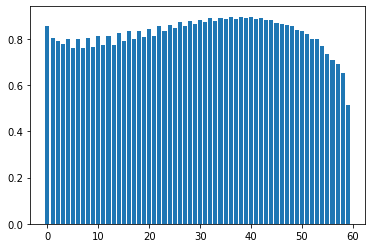

In [12]:
root = f"ckpts/bias/probes/state_tl256_b95"
with open(f"{root}/layer6/tensorboard.txt") as file:
    j = json.load(file)
    strat = j['test_strat_acc_cont'][-1]
    plt.bar(range(len(strat)), strat)

## Attempting to get probe accuracy per board square

In [34]:
layer = 6
model_ckpt = "bias/TLcontrol"

In [35]:
# loading games and creating activation dataset for probe
othello = Othello(n_games=10000, deduplicate=False)
train_dataset = CharDataset(othello)

mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, n_layer=8, n_head=8, n_embd=512)
model = GPTforProbing(mconf, probe_layer=layer)

# model.apply(model._init_weights)
load_res = model.load_state_dict(torch.load(f"./ckpts/{model_ckpt}.ckpt"))
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model = model.to(device)

loader = DataLoader(train_dataset, shuffle=False, pin_memory=True, batch_size=1, num_workers=1)
act_container = []
property_container = []
for x, y in tqdm(loader, total=len(loader)):
    tbf = [train_dataset.itos[_] for _ in x.tolist()[0]]
    valid_until = tbf.index(-100) if -100 in tbf else 999
    a = OthelloBoardState()
    properties = a.get_gt(tbf[:valid_until], "get_state")  # [block_size, ]
    act = model(x.to(device))[0, ...].detach().cpu()  # [block_size, f]
    act_container.extend([_[0] for _ in act.split(1, dim=0)[:valid_until]])
    property_container.extend(properties)
    
age_container = []
for x, y in tqdm(loader, total=len(loader)):
    tbf = [train_dataset.itos[_] for _ in x.tolist()[0]]
    valid_until = tbf.index(-100) if -100 in tbf else 999
    a = OthelloBoardState()
    ages = a.get_gt(tbf[:valid_until], "get_age")  # [block_size, ]
    age_container.extend(ages)

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 11.78 GB:   0%|          | 0/50 [00:00<?, ?it/s]


Loaded 100000 from 1 files
Using 8000 for training, 2000 for validation
Dataset created has 8000 sequences, 61 unique words.


100%|██████████| 8000/8000 [00:36<00:00, 217.80it/s]


In [36]:
class ProbingDataset(Dataset):
    def __init__(self, act, y, age):
        assert len(act) == len(y)
        assert len(act) == len(age)
        print(f"{len(act)} pairs loaded...")
        self.act = act
        self.y = y
        self.age = age
        print(np.sum(np.array(y)==0), np.sum(np.array(y)==1), np.sum(np.array(y)==2))
        
        long_age = []
        for a in age:
            long_age.extend(a)
        long_age = np.array(long_age)
        counts = [np.count_nonzero(long_age == i) for i in range(60)]
        del long_age
        print(counts)
    def __len__(self, ):
        return len(self.y)
    def __getitem__(self, idx):
        return self.act[idx], torch.tensor(self.y[idx]).to(torch.long), torch.tensor(self.age[idx]).to(torch.long)

probing_dataset = ProbingDataset(act_container, property_container, age_container)
train_size = int(0.8 * len(probing_dataset))
test_size = len(probing_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])
sampler = None
train_loader = DataLoader(train_dataset, shuffle=False, sampler=sampler, pin_memory=True, batch_size=128, num_workers=1)
test_loader = DataLoader(test_dataset, shuffle=True, pin_memory=True, batch_size=128, num_workers=1)

471899 pairs loaded...
7900614 14157547 8143375
[1515459, 1782766, 1735715, 1529575, 1490261, 1324987, 1291229, 1157087, 1126770, 1016684, 989354, 898492, 873776, 797248, 774466, 709746, 689250, 634482, 615451, 568703, 550901, 510919, 494426, 459572, 444106, 413969, 399394, 372739, 359007, 335862, 322864, 302437, 290069, 271827, 260024, 243673, 232356, 217552, 206741, 193286, 182855, 170521, 160473, 149129, 139490, 128866, 119519, 109664, 100579, 91207, 82415, 73485, 65011, 56543, 48286, 40123, 32075, 24039, 16022, 8009]


In [37]:
probe = BatteryProbeClassificationTwoLayer(device, probe_class=3, num_task=64, mid_dim=256)
load_res = probe.load_state_dict(torch.load(f"./ckpts/bias/probes/state_tl256_control/layer6/checkpoint.ckpt"))

probe = probe.to(device)

In [38]:
total_games = 0
total_correct = np.zeros(64)

pbar = tqdm(enumerate(train_loader), total=len(train_loader))
for it, (x, y, age) in pbar:
    x = x.to(device)  # [B, f]
    y = y.to(device)  # [B, #task=64] 
    age = age.to(device)  # [B, #task=64], in 0--59

    logits, loss = probe(x, y)
    pred = torch.argmax(logits, dim=2)

    correct = torch.sum(pred == y, dim=0)
    correct = correct.detach().cpu().numpy()
    np.add(total_correct, correct, out=total_correct)

    total_games += x.shape[0]

print(total_games)
print(total_correct)
print(sum(total_correct) / (total_games * 64))


100%|██████████| 2950/2950 [00:18<00:00, 157.36it/s]

377519
[369379. 373125. 373459. 374206. 373451. 373325. 373250. 373211. 372699.
 372030. 370299. 369272. 369497. 370858. 372329. 373230. 372565. 370611.
 367296. 365061. 365345. 368216. 370991. 373115. 374095. 369772. 365225.
 360688. 361546. 365384. 369882. 373948. 373451. 370091. 365172. 361333.
 361442. 364655. 369695. 373946. 374020. 370605. 368085. 365472. 365655.
 367749. 370426. 373362. 372030. 371854. 371107. 370017. 369577. 370994.
 371908. 370954. 373348. 371599. 372562. 373739. 373961. 373371. 373268.
 371986.]
0.9806954252633642


In [12]:
baseline = np.load("visuals/data/probe_baseline_simple_10k.npy")

<AxesSubplot:>

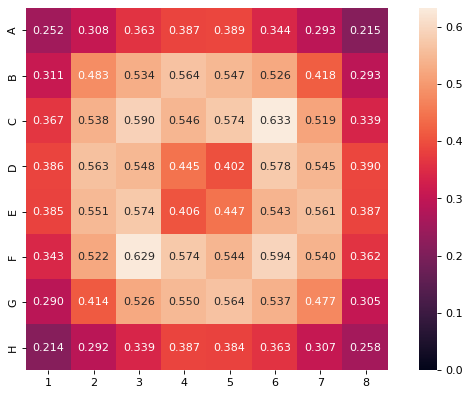

In [39]:
import seaborn as sns

avg = total_correct / total_games
diff = avg - baseline
fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(diff.reshape(8, 8), vmin=0,
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".3f")

In [40]:
np.save("visuals/data/probe_acc/control", avg)

### probe accuracy vs baseline

In [65]:
baseline = np.load("visuals/data/probe_baseline_time_10k.npy")

In [66]:
files = ["control", "b50", "b80", "b95"]
data = {}
for f in files:
    data[f] = np.load(f"visuals/data/probe_acc/{f}.npy")
    data[f] = data[f] - baseline

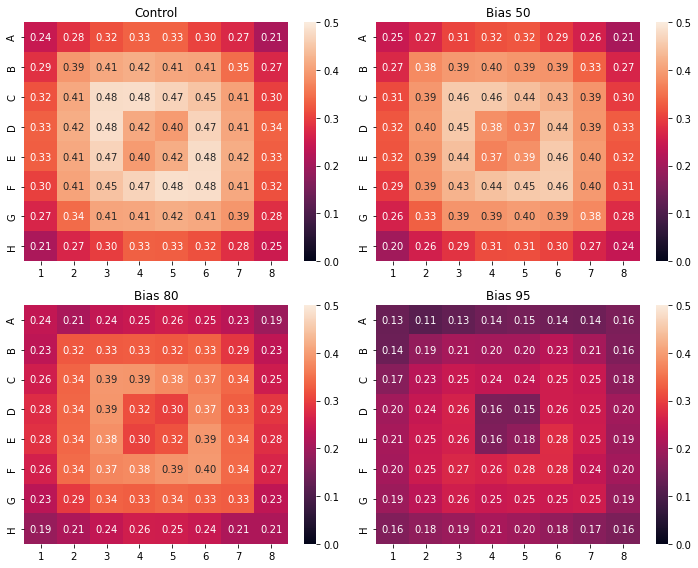

In [69]:
import seaborn as sns

def heat(axs, data):
    sns.heatmap(data=data.reshape((8, 8)), ax=axs, vmin=0, vmax=0.5, 
                annot=True, fmt=".2f",
                yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)))

# Create the subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the heatmaps in each subplot
# sns.heatmap(data=data["control"].reshape((8, 8)), ax=axs[0, 0])
# sns.heatmap(data=data["b50"].reshape((8, 8)), ax=axs[0, 1])
# sns.heatmap(data=data["b80"].reshape((8, 8)), ax=axs[1, 0])
# sns.heatmap(data=data["b95"].reshape((8, 8)), ax=axs[1, 1])
heat(axs[0, 0], data["control"])
heat(axs[0, 1], data["b50"])
heat(axs[1, 0], data["b80"])
heat(axs[1, 1], data["b95"])

# Add titles to the subplots (optional)
axs[0, 0].set_title('Control')
axs[0, 1].set_title('Bias 50')
axs[1, 0].set_title('Bias 80')
axs[1, 1].set_title('Bias 95')

# Adjust the spacing between subplots (optional)
plt.tight_layout()

# Display the figure
plt.show()